In [ ]:
!pip install qiskit
!pip install qiskit-Aer
!pip install qiskit-algorithms
!pip install qiskit-optimization
!pip install qiskit-ibm-runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 635.6/635.6 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import time

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library import QAOAAnsatz, TwoLocal
from qiskit_optimization.applications import Tsp
from qiskit_algorithms.minimum_eigensolvers import SamplingVQE
from qiskit_algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, POWELL
# from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit.quantum_info import Operator, SparsePauliOp
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from scipy.optimize import minimize


# `1. TSP solved via quadratic programming on simulator (adapted from qiskit tutorials)`

In [ ]:
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


In [ ]:
n = 4
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
distance_matrix = nx.to_numpy_array(tsp.graph)
distance_matrix

array([[ 0., 48., 91., 33.],
       [48.,  0., 63., 71.],
       [91., 63.,  0., 92.],
       [33., 71., 92.,  0.]])

In [ ]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_3 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_3
  + 33*x_0_0*x_3_1 + 33*x_0_0*x_3_3 + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2
  + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2 + 33*x_0_1*x_3_0 + 33*x_0_1*x_3_2
  + 48*x_0_2*x_1_1 + 48*x_0_2*x_1_3 + 91*x_0_2*x_2_1 + 91*x_0_2*x_2_3
  + 33*x_0_2*x_3_1 + 33*x_0_2*x_3_3 + 48*x_0_3*x_1_0 + 48*x_0_3*x_1_2
  + 91*x_0_3*x_2_0 + 91*x_0_3*x_2_2 + 33*x_0_3*x_3_0 + 33*x_0_3*x_3_2
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_3 + 71*x_1_0*x_3_1 + 71*x_1_0*x_3_3
  + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2 + 71*x_1_1*x_3_0 + 71*x_1_1*x_3_2
  + 63*x_1_2*x_2_1 + 63*x_1_2*x_2_3 + 71*x_1_2*x_3_1 + 71*x_1_2*x_3_3
  + 63*x_1_3*x_2_0 + 63*x_1_3*x_2_2 + 71*x_1_3*x_3_0 + 71*x_1_3*x_3_2
  + 92*x_2_0*x_3_1 + 92*x_2_0*x_3_3 + 92*x_2_1*x_3_0 + 92*x_2_1*x_3_2
  + 92*x_2_2*x_3_1 + 92*x_2_2*x_3_3 + 92*x_2_3*x_3_0 + 92*x_2_3*x_3_2

Subject to
  Linear constraints (8)
    x_0_0 + x_0_1 + x_0_2 + x_0_3 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 + x_1_3 == 1  'c1'
    x_2

In [ ]:
qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
hamiltonian, offset = qubo.to_ising()
print(hamiltonian)

SparsePauliOp(['IIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIZII', 'IIIIIIIIIIIIZIII', 'IIIIIIIIIIIZIIII', 'IIIIIIIIIIZIIIII', 'IIIIIIIIIZIIIIII', 'IIIIIIIIZIIIIIII', 'IIIIIIIZIIIIIIII', 'IIIIIIZIIIIIIIII', 'IIIIIZIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZZ', 'IIIIIIIIIIIIIZIZ', 'IIIIIIIIIIIIZIIZ', 'IIIIIIIIIIIZIIIZ', 'IIIIIIIIIIZIIIIZ', 'IIIIIIIIZIIIIIIZ', 'IIIIIIIZIIIIIIIZ', 'IIIIIIZIIIIIIIIZ', 'IIIIZIIIIIIIIIIZ', 'IIIZIIIIIIIIIIIZ', 'IIZIIIIIIIIIIIIZ', 'ZIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIZZI', 'IIIIIIIIIIIIZIZI', 'IIIIIIIIIIIZIIZI', 'IIIIIIIIIIZIIIZI', 'IIIIIIIIIZIIIIZI', 'IIIIIIIZIIIIIIZI', 'IIIIIIZIIIIIIIZI', 'IIIIIZIIIIIIIIZI', 'IIIZIIIIIIIIIIZI', 'IIZIIIIIIIIIIIZI', 'IZIIIIIIIIIIIIZI', 'IIIIIIIIIIIIZZII', 'IIIIIIIIIIZIIZII', 'IIIIIIIIIZIIIZII', 'IIIIIIIIZIIIIZII', 'IIIIIIZIIIIIIZII', 'IIIIIZIIIIIIIZII', 'IIIIZIIIIIIIIZII', 'IIZIIIIIIIIIIZII', 'IZIIIIIIIIIIIZII', 'ZIIIIIIIIIIIIZII', 'IIII

In [ ]:
counts = []
values = []
def samplevqe_callback(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
    # print(f"Current parameters: {parameters}, Objective value: {mean}")

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


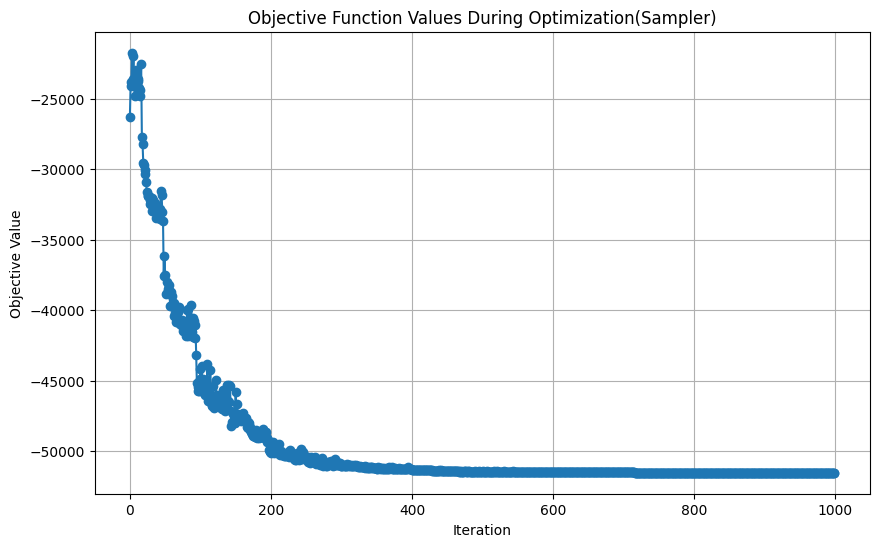

Sampling time 1451.2234177589417


In [ ]:
optimizer = COBYLA(maxiter=1000)

# backend = AerSimulator(method="matrix_product_state")

sampler = Sampler()

p = 1

# ansatz = QAOAAnsatz(hamiltonian, reps=p)

ansatz = TwoLocal(hamiltonian.num_qubits, "ry", "rzz", reps=p, entanglement="linear")
init_point = np.random.random(ansatz.num_parameters)

start_time = time.time()
sampling_vqe = SamplingVQE(sampler, ansatz, optimizer, initial_point=init_point, callback=samplevqe_callback)
result_samp = sampling_vqe.compute_minimum_eigenvalue(hamiltonian)
end_time = time.time()

plt.figure(figsize=(10, 6))
plt.plot(values, marker="o")
plt.title("Objective Function Values During Optimization(Sampler)")
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.grid(True)
plt.show()
print("Sampling time", end_time-start_time)

In [ ]:
# from qiskit import transpile
# trans = transpile(ansatz, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=3)
# decompose_circ = trans.decompose()
# trans.draw('mpl', style='iqp')

feasible: True
solution: [0, 1, 2, 3]
solution objective: 236.0


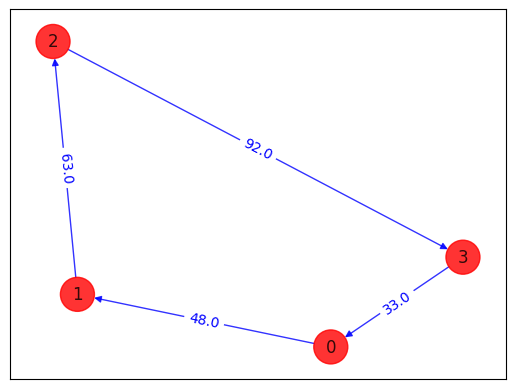

In [ ]:
x = tsp.sample_most_likely(result_samp.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, distance_matrix))
colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_tsp_solution(tsp.graph, z, colors, pos)

## `2. This code explicitly develops TSP QUBO and solves it on simulator/hardware.`

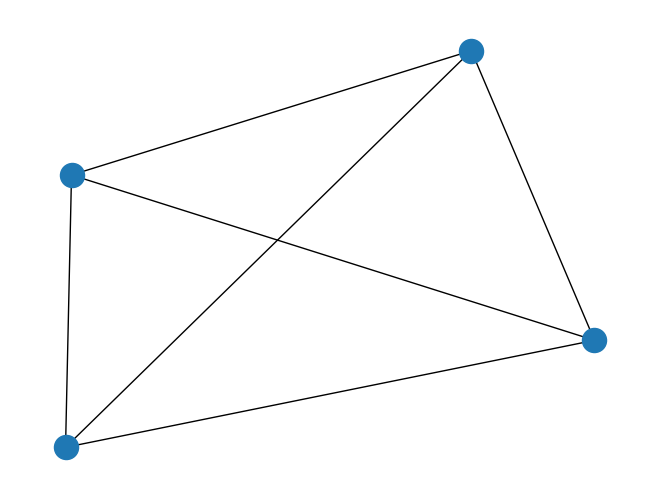

In [ ]:
G = tsp.graph
N = num_qubits
Q = distance_matrix
nx.draw(tsp.graph)

In [65]:
def append_zz_term(qc, q1, q2, gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1,q2)
    return qc


# In[34]:


def append_z_term(qc, q1, gamma):
    qc.rz(2*gamma, q1)
    return qc


# In[35]:


def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)
    return qc


# In[36]:


def get_cost_operator_circuit(G, gamma):
#    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for i in range(N):
        append_z_term(qc, i, gamma)
    for i in range(N):
        for j in range(N):
            if i<j:
                append_zz_term(qc,i,j,gamma)
    return qc


# In[37]:


def get_mixer_operator_circuit(G, beta):
#    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for n in range(N):
        append_x_term(qc, n, beta)
    return qc


# In[38]:


def get_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta)
#    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)

    # First apply Hadamard layer
    qc.h(range(N))

    #Second apply p alternating operators
    for i in range(p):
        qc = qc.compose(get_cost_operator_circuit(G, gamma[i]))
        qc = qc.compose(get_mixer_operator_circuit(G, beta[i]))

    #Finally, measure the result
    # qc.barrier(range(N))
    qc.measure(range(N), range(N))
    # qc.measure_all()

    return qc


# In[39]:


def invert_counts(counts):
    return {k[::-1]:v for k,v in counts.items()}


# In[40]:


def qubo_obj(string,G):

    A = 100
    n = G.number_of_nodes()
    g = n
    # Convert the string to a 1D array of integers using list comprehension
    array1d = np.array([int(i) for i in string])

    # Reshape the 1D array into a 2D array of size 2x2
    x = array1d.reshape((g,g))


    summ1, row_sum, col_sum = 0,0,0
    summ2, summ3, tot_sum = 0,0,0

    #Qubo term
    for i in range(g):
        for j in range(g):
            for k in range(g):
                for l in range(g):
                    if i<j and k != l:
                        summ1 += x[i][k]*x[j][l]*Q[i][j]/2

    #Row and Col summations
    row_sum = np.sum(x, axis = 1)
    col_sum = np.sum(x, axis = 0)

    #Penalty terms
    summ2 = np.sum((1-row_sum)**2)
    summ3 = np.sum((1-col_sum)**2)

    tot_sum = summ1 + A*(summ2 + summ3)

    return tot_sum



obj_values = []
# Callback function to record optimization progress
def callback(xk):
    fx = obj(xk)
    obj_values.append(fx)
    print(f"Current parameters: {xk}, Objective value: {fx}")




# 2a. AerSimulator

In [66]:
def compute_qubo_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = qubo_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy/total_counts


def get_black_box_objective(G,p):
    backend = AerSimulator(method='statevector')
    def f(theta):
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit(G, beta, gamma)
        # qc.measure_all()
        counts = backend.run(qc).result().get_counts()
        return compute_qubo_energy(invert_counts(counts), G)
    return f



Current parameters: [2.02075152 6.264926   2.04362559 1.93315468 0.38626745 2.02021799
 0.3516705  5.29760783 2.97252677 3.67841642], Objective value: 4951.6220703125
Current parameters: [1.02075152 7.264926   2.04362559 1.93315468 0.38626745 2.02021799
 0.3516705  5.29760783 2.97252677 3.67841642], Objective value: 2638.38916015625
Current parameters: [1.02075152 6.264926   3.04362559 1.93315468 0.38626745 2.02021799
 0.3516705  5.29760783 2.97252677 3.67841642], Objective value: 3540.603515625
Current parameters: [1.02075152 6.264926   2.04362559 2.93315468 0.38626745 2.02021799
 0.3516705  5.29760783 2.97252677 3.67841642], Objective value: 3262.052734375
Current parameters: [1.02075152 6.264926   2.04362559 1.93315468 1.38626745 2.02021799
 0.3516705  5.29760783 2.97252677 3.67841642], Objective value: 4580.76904296875
Current parameters: [1.02075152 6.264926   2.04362559 1.93315468 0.38626745 3.02021799
 0.3516705  5.29760783 2.97252677 3.67841642], Objective value: 3141.461425781

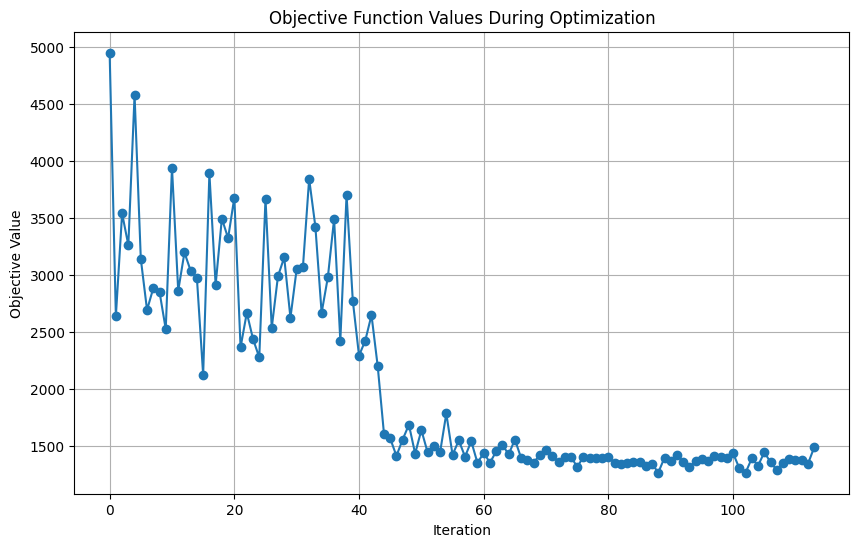

109.4239764213562 s


In [67]:
import time
start = time.time()
backend = AerSimulator(method='statevector')
p = 5
obj = get_black_box_objective(G, p)

init_point = 2*np.pi * np.random.random(2*p)
res_sample = minimize(obj, init_point, method = 'COBYLA', options = {'maxiter':1000, 'disp':True}, callback=callback)

plt.figure(figsize=(10, 6))
plt.plot(obj_values, marker="o")
plt.title("Objective Function Values During Optimization")
plt.xlabel("Iteration")
plt.ylabel("Objective Value")
plt.grid(True)
plt.show()

optimal_theta = res_sample['x']
qc = get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
# qc.measure_all()
trans_qc = transpile(qc, optimization_level=2)
counts = backend.run(trans_qc).result().get_counts()
end = time.time()
print((end-start),"s")

In [68]:
from operator import itemgetter
min_engy, optimal_string = min([(qubo_obj(x, G), x) for x in counts.keys()], key=itemgetter(0))


In [69]:
def array_arrange(optimal_string):
    array1d = np.array([int(i) for i in optimal_string])
    mtrx = array1d.reshape((n,n))


    all_zero_cols = np.where(np.all(mtrx == 0, axis=0))[0]
    all_zero_rows = np.where(np.all(mtrx == 0, axis=1))[0]

    mtrx[all_zero_rows, all_zero_cols] = 1

    mtrx_str = ''.join(map(str, mtrx.flatten()))

    str_by_sw = [mtrx_str[i:i + n] for i in range(0, len(mtrx_str) + 1, n)]
    sol = {i:t for i in range(n) for t in range(n) if mtrx_str[i * n + t] == '1'}
    print(mtrx, mtrx_str, "\n")
    return sol

In [70]:
def solution_walk(optimal_string):

    solution = array_arrange(optimal_string)

    distance = sum(
    G[u][v]["weight"] for u, v in G.edges
    if solution[u] == (solution[v] + 1) % n or solution[v] == (solution[u] + 1) % n)
    print("The walk found by parameterized quantum circuit:", solution, "with distance", distance)

    # Create labels and edge colors
    labels = {i: f"{i}, {t}" for i, t in solution.items()}
    edge_colors = [
        "red" if solution[u] == (solution[v] + 1) % n or solution[v] == (solution[u] + 1) % n else "black"
        for u, v in G.edges
    ]
    return labels, edge_colors

[[0 0 0 1]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]] 0001001010000100 

The walk found by parameterized quantum circuit: {0: 3, 1: 2, 2: 0, 3: 1} with distance 302.0


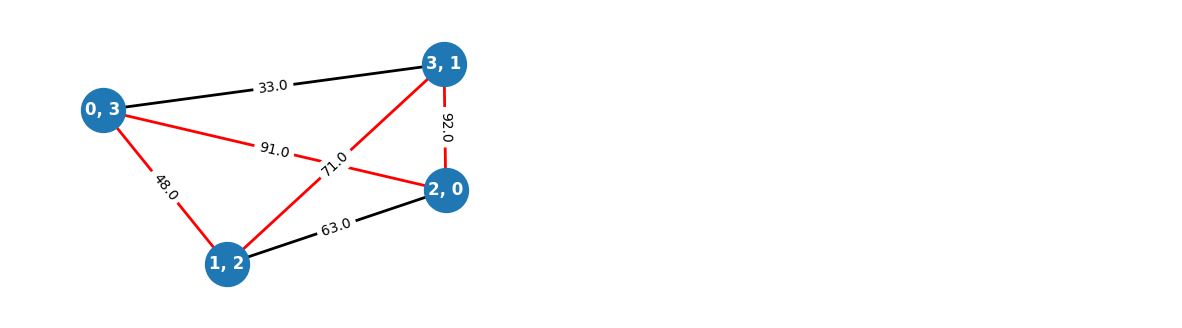

In [71]:
# Plot the graph
pos = nx.spring_layout(G)
options = {
    "with_labels": True,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 1000,
    "width": 2
}

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for a in ax:
    a.axis('off')
    a.margins(0.20)

labels, edge_colors = solution_walk(optimal_string)

nx.draw(G, pos=pos, labels=labels, edge_color=edge_colors, ax=ax[0], **options)
edge_weights = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=pos, ax=ax[0], edge_labels=edge_weights)
nx.draw_networkx_edge_labels(G, pos=pos, ax=ax[1], edge_labels=edge_weights)

plt.show()

# 2b. IBM Hardware

In [59]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler, Session, Options, QiskitRuntimeService
from operator import itemgetter
# service = QiskitRuntimeService(channel="ibm_quantum", token="")


In [60]:
backend = service.get_backend("ibm_kyiv")
p=5

init_point = 2*np.pi * np.random.random(2*p)

qc = get_qaoa_circuit(G, init_point[:p], init_point[p:])
qc.measure_all()
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(qc)
with Session(service=service, backend=backend) as session:
    sampler = Sampler(session=session)
    options=Options()
    smapler = Sampler()
    sampler.options.update(default_shots=4096, dynamical_decoupling={"sequence_type": "XY4"})
    job = sampler.run([isa_circuit])
    print(f">>> Job ID: {job.job_id()}")
    print(f">>> Job Status: {job.status()}")
    result = job.result()
    session.close()

>>> Job ID: cs4tnnp75q40008tw21g
>>> Job Status: QUEUED


RuntimeInvalidStateError: 'Unable to retrieve result for job cs4tnnp75q40008tw21g. Job was cancelled.'

In [ ]:
counts = result[0].data.meas.get_counts()
best_cut, best_solution = min([(qubo_obj(x, G), x) for x in counts.keys()], key=itemgetter(0))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
for a in ax:
    a.axis('off')
    a.margins(0.20)

labels, edge_colors = solution_walk(best_solution)

nx.draw(G, pos=pos, labels=labels, edge_color=edge_colors, ax=ax[0], **options)
edge_weights = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=pos, ax=ax[0], edge_labels=edge_weights)
nx.draw_networkx_edge_labels(G, pos=pos, ax=ax[1], edge_labels=edge_weights)

plt.show()